<a href="https://colab.research.google.com/github/kjxeez/machine-learning/blob/main/Poly_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 2


### Дисциплина: Методы машинного обучения

##### Студент:  Акопян Изабелла Арменовна
##### Группа:   НБИ-01-20

## Москва 2023
***

### Вариант № 11

Лабораторная работа 2 – Вариант 11 

1. Набор данных: forest_fires 

2. Независимая переменная: features/FFMC 

3. Зависимая переменная: features/DMC 

4. Доп. признак: имеющий максимальную дисперсию 

5. Визуализация доп. признака – столбчатая диаграмма 

6. Показатель качества регрессии – MAE (mean absolute error) 

7. Степень полинома: 4 

8. Параметры глубокой нейронной сети: кол-во скрытых слоев – 4, кол-во нейронов в скрытом слое – 64, функция активации – сигмоида. 

В соответствии с индивидуальным заданием, указанным в записной книжке команды, выполните следующие работы:  

1. Загрузите заданный в индивидуальном задании набор данных из Tensorflow Datasets, включая указанные в задании независимый признак и зависимый признак (отклик). 

2. Решите задачу полиномиальной регрессии для степени полинома, указанной в индивидуальном задании, при помощи нейронной сети с одним нейроном и оцените качество полученной модели по показателю, указанному в индивидуальном задании.  
3. Постройте кривые обучения с зависимостью от количества эпох. 
4. Визуализируйте точки набора данных на плоскости в виде диаграммы рассеяния (ось X – независимый признак, ось Y – зависимый признак), а также линию регрессии (другим цветом), подписывая оси и рисунок.  
5. Определите в исходном наборе данных признак (отличный от независимого и зависимого признаков), принимающий непрерывные значения и имеющий свойства, указанные в индивидуальном задании.  
6. Визуализируйте этот признак в соответствии с индивидуальным заданием.  
7. Сформируйте набор входных данных из двух признаков набора данных (независимый признак и определенный признак), создайте и адаптируйте нормализующий слой Tensorflow для двух признаков.  
8. Используя созданный нормализующий слой, постройте нейронную сеть (нелинейный регресор) с количеством скрытых слоев, количеством нейронов и функцией активации, указанными в индивидуальном задании, и одним нейроном в выходном слое и обучите ее на наборе данных из двух признаков и отклика.  
9. Визуализируйте набор данных в виде точечного графика и прогноз нейронной сети в виде поверхности в трехмерном пространстве. 
10. Разбейте набор данных из двух признаков и отклика на обучающую и тестовую выборки и постройте кривые обучения для заданного показателя качества в зависимости от количества точек в обучающей выборке, подписывая оси и рисунок и создавая легенду. 

## Решение:

In [112]:
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import learning_curve


Загрузите заданный в индивидуальном задании набор данных из Tensorflow Datasets, включая указанные в задании независимый признак и зависимый признак (отклик).

Независимая переменная: features/FFMC

Зависимая переменная: features/DMC

Доп. признак: имеющий максимальную дисперсию 

In [186]:
dataset = tfds.load("forest_fires", split='train') 
df = tfds.as_dataframe(dataset)
df.head()

,area,features/DC,features/DMC,features/FFMC,features/ISI,features/RH,features/X,features/Y,features/day,features/month,features/rain,features/temp,features/wind
0,10.820000,671.200012,181.100006,96.099998,14.300000,63.0,7,5,1,7,6.4,27.299999,4.9
1,24.590000,750.500000,96.699997,90.500000,11.400000,55.0,3,4,6,8,0.0,20.600000,5.4
2,0.170000,607.099976,131.699997,94.300003,22.700001,55.0,6,5,1,7,0.0,19.400000,4.0
3,14.680000,671.200012,181.100006,96.099998,14.300000,27.0,3,4,1,7,0.0,32.299999,2.2
4,88.489998,699.599976,133.300003,92.900002,9.200000,21.0,4,4,2,8,0.0,26.400000,4.5


In [203]:
X = df['features/FFMC'] # вектор
y = df['features/DMC']

Решите задачу полиномиальной регрессии для степени полинома, указанной в индивидуальном задании, при помощи нейронной сети с одним нейроном и оцените качество полученной модели по показателю, указанному в индивидуальном задании.

Независимая переменная: features/FFMC

Зависимая переменная: features/DMC

In [252]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)

In [253]:
poly = PolynomialFeatures(degree=4) #4 уровня обучения
X_train = poly.fit_transform(X_train.values.reshape(-1, 1))
X_test = poly.transform(X_test.values.reshape(-1, 1))

In [254]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
# Нормализующий слой для всех признаков
feature_normalizer = tf.keras.layers.Normalization(axis=None,input_shape=(5,))
# Адаптация нормализующего слоя на обучающих данных
feature_normalizer.adapt(X_train)
     

In [255]:
poly_model = tf.keras.Sequential([
    feature_normalizer,
    tf.keras.layers.Dense(units=1, input_dim=X_train.shape[1])
])
poly_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')
history = poly_model.fit(
    X_train, y_train, 
    epochs=100,
    # уровень выводимой информации
    verbose=1,
    # проверка (валидация)
    validation_data=(X_test, y_test))

Epoch 1/100
12/12 [==============================] - 1s 17ms/step - loss: 108.0077 - val_loss: 110.0604
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: 107.4145 - val_loss: 109.4679
Epoch 3/100
12/12 [==============================] - 0s 5ms/step - loss: 106.8209 - val_loss: 108.8784
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 106.2305 - val_loss: 108.2953
Epoch 5/100
12/12 [==============================] - 0s 5ms/step - loss: 105.6455 - val_loss: 107.7174
Epoch 6/100
12/12 [==============================] - 0s 5ms/step - loss: 105.0710 - val_loss: 107.1450
Epoch 7/100
12/12 [==============================] - 0s 6ms/step - loss: 104.5013 - val_loss: 106.5734
Epoch 8/100
12/12 [==============================] - 0s 6ms/step - loss: 103.9363 - val_loss: 106.0034
Epoch 9/100
12/12 [==============================] - 0s 6ms/step - loss: 103.3727 - val_loss: 105.4372
Epoch 10/100
12/12 [==============================] - 0s 5ms/step - loss

In [287]:
y_test_pred = poly_model.predict(np.sort(X_test)).ravel()
mae_test = mean_absolute_error(y_test, y_test_pred)
print('Test MAE:', mae_test)

5/5 [==============================] - 0s 2ms/step
Test MAE: 67.79887


Постройте кривые обучения с зависимостью от количества эпох.

In [288]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylim([60, max(history.history['loss'])*1.1])
  plt.title('Процесс обучения модели')
  plt.xlabel('Эпохи обучения')
  plt.ylabel('Ошибка')
  plt.legend(['loss', 'val_loss'], loc='upper right')
  plt.grid(True)

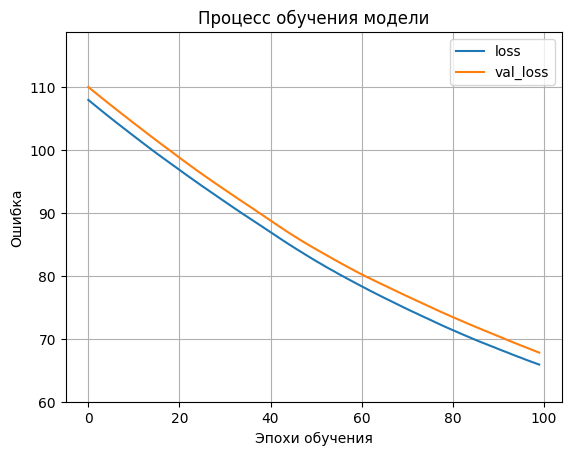

In [289]:
plot_loss(history)

Визуализируйте точки набора данных на плоскости в виде диаграммы рассеяния (ось X – независимый признак, ось Y – зависимый признак), а также линию регрессии (другим цветом), подписывая оси и рисунок.

In [290]:
y_train.shape

(361,)

In [291]:
X_train.shape

(361, 5)

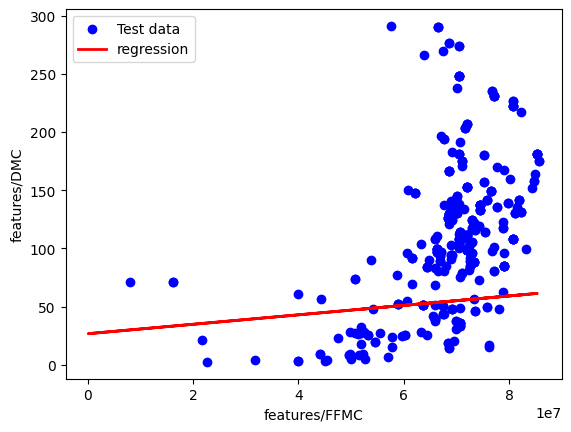

In [305]:
plt.scatter(X_train[:, 4], y_train, color='blue', label='Test data')

plt.plot(X_test[:,4], y_test_pred, color='red', linewidth=2, label='regression')

plt.xlabel('features/FFMC')
plt.ylabel('features/DMC')
plt.legend()
plt.show()

Определите в исходном наборе данных признак (отличный от независимого и зависимого признаков), принимающий непрерывные значения и имеющий свойства, указанные в индивидуальном задании.

In [160]:
variances = df.var()
max_variance = variances.max()
print(variances)

area               4052.063232
features/DC       61536.835938
features/DMC       4101.951660
features/FFMC        30.471624
features/ISI         20.788832
features/RH         266.259796
features/X            5.353568
features/Y            1.512655
features/day          4.297033
features/month        5.180131
features/rain         0.087592
features/temp        33.716896
features/wind         3.210019
dtype: float64


features/DC       61536.835938 - непрерывен и имеет наибольшую дисперсию. берем его как доп признак


Визуализируйте этот признак в соответствии с индивидуальным заданием.

Визуализация доп. признака – столбчатая диаграмма

[Text(0, 0.5, 'features/FFMC'), Text(0.5, 0, 'Индекс пожара')]

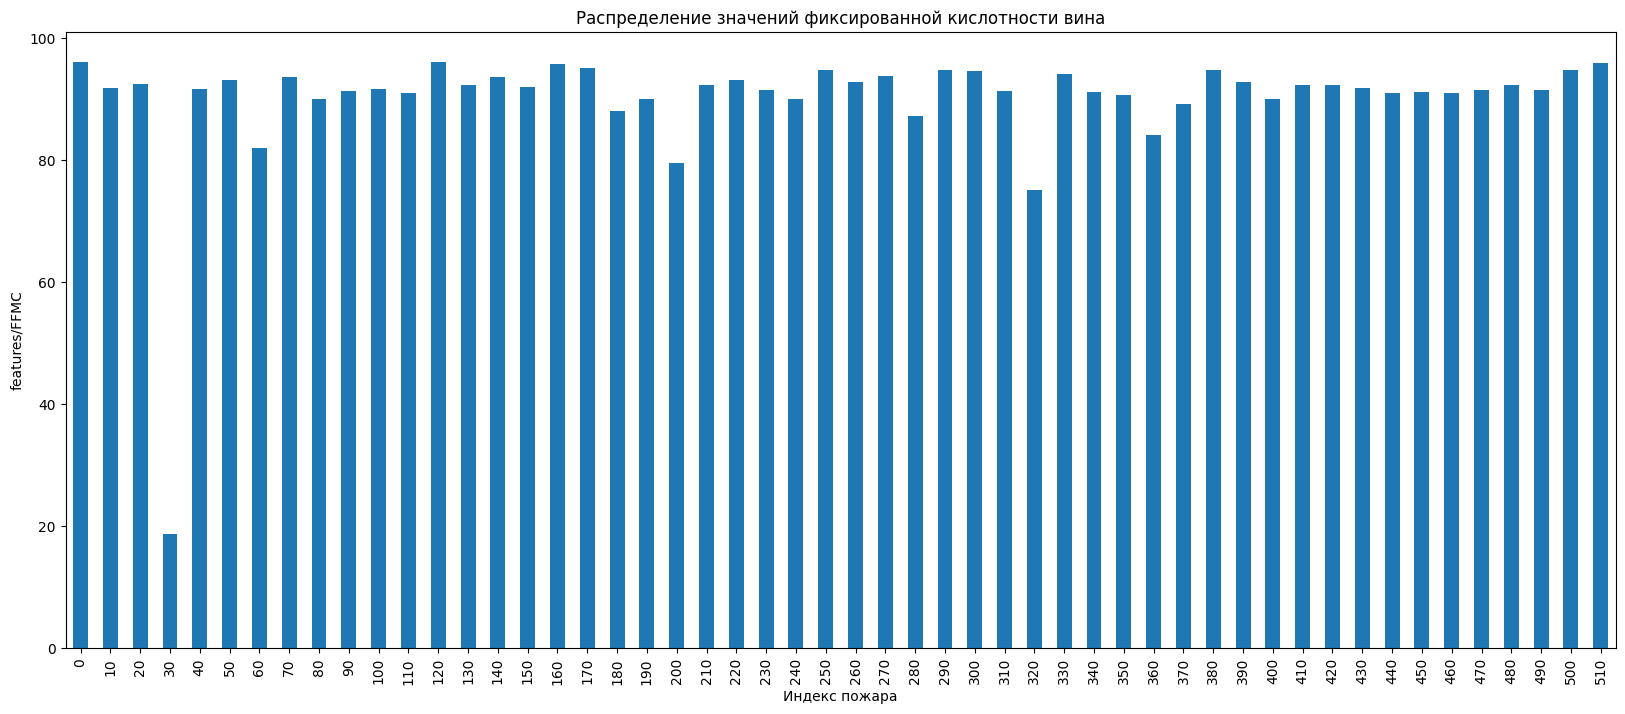

In [309]:
df[::10]['features/FFMC'].plot.bar(title='Распределение значений фиксированной кислотности вина', figsize=(20,8)).set(ylabel='features/FFMC', xlabel = 'Индекс пожара')
     

Сформируйте набор входных данных из двух признаков набора данных (независимый признак и определенный признак), создайте и адаптируйте нормализующий слой Tensorflow для двух признаков.

In [311]:
X = df[['features/FFMC', 'features/DC']]
y = df['features/DMC']
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)

In [312]:
# Создание и адаптация нормализующего слоя
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(X_train)

Используя созданный нормализующий слой, постройте нейронную сеть (нелинейный регресор) с количеством скрытых слоев, количеством нейронов и функцией активации, указанными в индивидуальном задании, и одним нейроном в выходном слое и обучите ее на наборе данных из двух признаков и отклика.

In [313]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((361, 2), (156, 2), (361,), (156,))

сигмоида и 4 скрытых слоя


In [314]:

model = tf.keras.models.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')


train_score = []
test_score = []
history=[]
for i in range(10, 361, 10):
    history.append(model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test)))
    y_train_predict = model.predict(X_train[:i])
    train_score.append(mean_absolute_error(y_train[:i], y_train_predict))
    y_test_predict = model.predict(X_test)
    test_score.append(mean_absolute_error(y_test, y_test_predict))
    print('-->', i, ' done')

Выходные данные были обрезаны до нескольких последних строк (5000).
12/12 [==============================] - 0s 8ms/step - loss: 1810.1228 - val_loss: 1968.1168
Epoch 39/100
12/12 [==============================] - 0s 10ms/step - loss: 1808.0071 - val_loss: 1970.4531
Epoch 40/100
12/12 [==============================] - 0s 9ms/step - loss: 1811.4585 - val_loss: 1966.4928
Epoch 41/100
12/12 [==============================] - 0s 8ms/step - loss: 1809.6879 - val_loss: 1969.9313
Epoch 42/100
12/12 [==============================] - 0s 8ms/step - loss: 1810.7050 - val_loss: 1967.6210
Epoch 43/100
12/12 [==============================] - 0s 8ms/step - loss: 1804.5901 - val_loss: 1977.1344
Epoch 44/100
12/12 [==============================] - 0s 12ms/step - loss: 1809.9972 - val_loss: 1971.6625
Epoch 45/100
12/12 [==============================] - 0s 10ms/step - loss: 1804.3419 - val_loss: 1975.3506
Epoch 46/100
12/12 [==============================] - 0s 10ms/step - loss: 1799.5555 - val_los

Визуализируйте набор данных в виде точечного графика и прогноз нейронной сети в виде поверхности в трехмерном пространстве.

313/313 [==============================] - 1s 2ms/step


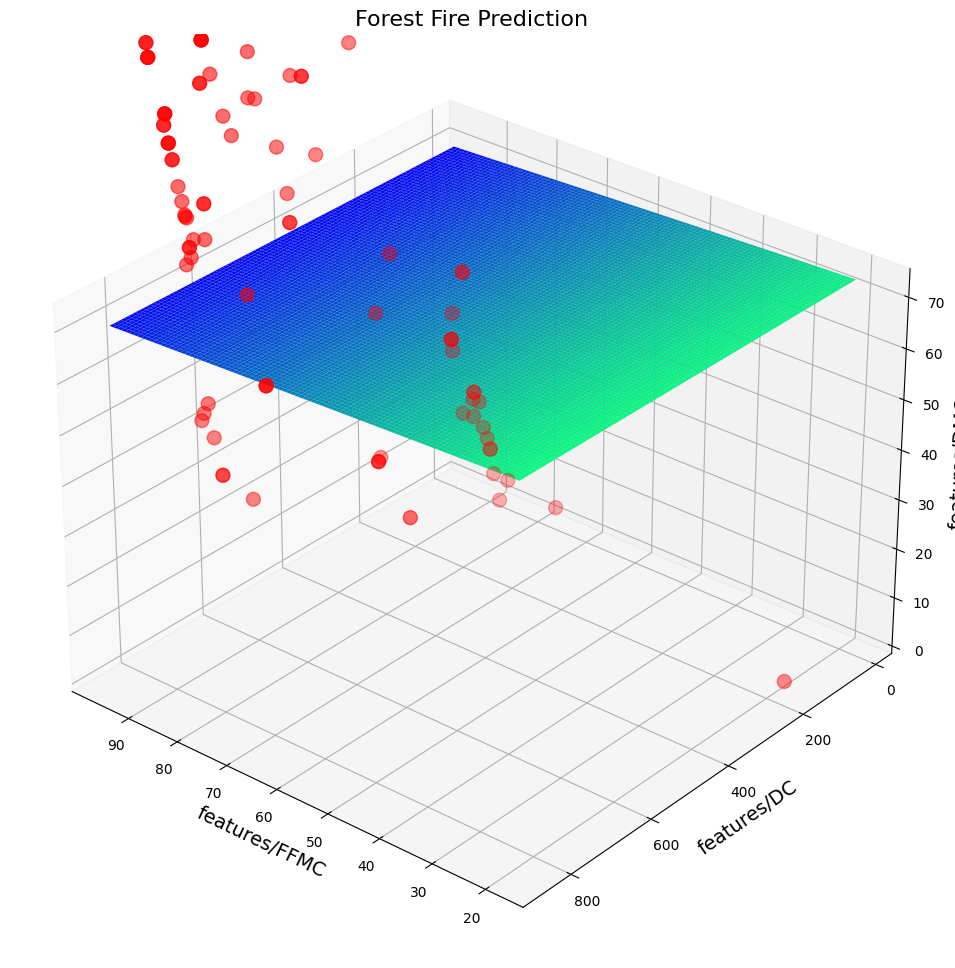

In [323]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')


x_mesh, y_mesh = np.meshgrid(np.linspace(X_test['features/FFMC'].min(), X_test['features/FFMC'].max(), 100), \
                             np.linspace(X_test['features/DC'].min(), X_test['features/DC'].max(), 100))
z_mesh = model.predict(normalizer(np.c_[x_mesh.ravel(), y_mesh.ravel()])).reshape(x_mesh.shape)

surf = ax.plot_surface(x_mesh, y_mesh, z_mesh, rstride=1, cstride=1, linewidth=0.05, cmap=cm.winter, antialiased=True,edgecolors='gray') 


xs = X_test['features/FFMC']
ys = X_test['features/DC']
zs = y_test
ax.scatter( xs, ys, zs, s=100, c='r' )


ax.set_xlabel('features/FFMC', fontsize=14) 
ax.set_ylabel('features/DC', fontsize=14)
ax.set_zlabel('features/DMC', fontsize=14) 
ax.set_title('Forest Fire Prediction', fontsize=16)


ax.set_zlim(0., z_mesh.max())


ax.view_init(elev = 30, azim = 130)

plt.show()

### №10
10.	Разбейте набор данных из двух признаков и отклика на обучающую и тестовую выборки и постройте кривые обучения для заданного показателя качества в зависимости от количества точек в обучающей выборке, подписывая оси и рисунок и создавая легенду.

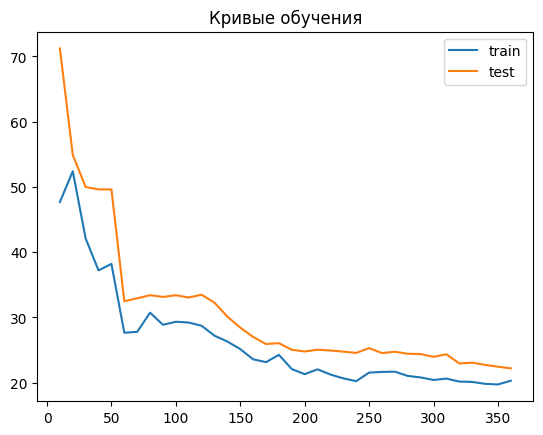

In [321]:
plt.plot([i for i in range(10, len(X_train), 10)], 
                               train_score, label="train")
plt.plot([i for i in range(10, len(X_train), 10)], 
                               test_score, label="test")
plt.title('Кривые обучения')
plt.legend();